In [1]:
import math
import torch
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


# Entropy $\mathcal{H}(p)$

The entropy measures how much uncertainty characterises a distribution. Mathematically, it is defined as:

\begin{equation}
    \mathcal{H}(p) = - \sum_{x\in \mathcal{X}}p(x)\log p(x)
\end{equation}

The more possible values there are for a sample drawed from that distribution, the higher the entropy of that distribution. This of course is affected by (1) the dimensionality of the distribution and (2) how the probability mass is distributed among the possible values.

For example, a categorical-K distribution will have a maximum entropy of $-\log(\frac{1}{K})$, and an entropy of 0 when only one value gets all the probability mass:

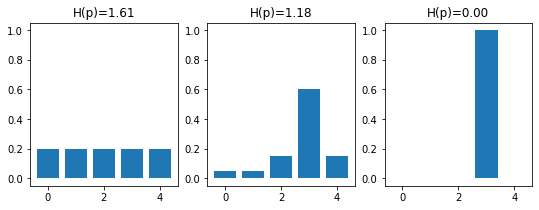

In [2]:
x = [0, 1, 2, 3, 4]
p_1 = torch.distributions.Categorical(probs=torch.tensor([0.2, 0.2, 0.2, 0.2, 0.2]))
p_2 = torch.distributions.Categorical(probs=torch.tensor([0.05, 0.05, 0.15, 0.6, 0.15]))
p_3 = torch.distributions.Categorical(probs=torch.tensor([0., 0., 0., 1., 0.]))

def plot_discrete_dist(x, p_x, ax):
    ax.bar(x, p_x.probs)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(f'H(p)={p_x.entropy():.2f}')

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, p in enumerate([p_1, p_2, p_3]):
    plot_discrete_dist(x, p, axes[i])

For continuous distribution, the entropy can actually be negative. For example, a Gaussian with standard deviation $\sigma=1$ has an entropy of about 1.4 whereas $\sigma=0.1$ leads to an entropy of about $-0.2$:

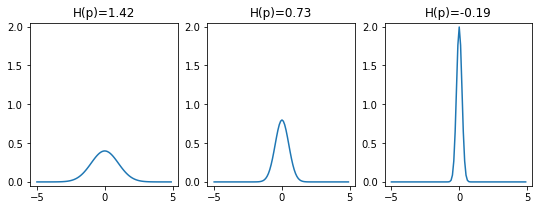

In [3]:
x = torch.arange(-5., 5., 0.1)
p_1 = torch.distributions.Normal(loc=0., scale=1.)
p_2 = torch.distributions.Normal(loc=0., scale=0.5)
p_3 = torch.distributions.Normal(loc=0., scale=0.2)

def plot_discrete_dist(x, p_x, ax):
    ax.plot(x, torch.exp(p_x.log_prob(x)))
    ax.set_ylim(-0.05, 2.05)
    ax.set_title(f'H(p)={p_x.entropy():.2f}')

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, p in enumerate([p_1, p_2, p_3]):
    plot_discrete_dist(x, p, axes[i])

While the entropy cannot be computed exactly for continuous distributions in general, because the sum in the definition of the entropy becomes an integral, a closed form expression exists for many common distributions. For example, the entropy of a multivariate gaussian is given by:
\begin{equation}
    \mathcal{H\big(\mathcal{N}(\mu, \Sigma)}\big) = \frac{1}{2} \log \big( det(2\pi e \Sigma) \big)
\end{equation}

# KL-divergence $D_{KL}(p||q)$

The Kullback Leibler divergence measures how different two distributions $p$ and $q$ are. Obviously, these two distributions must be defined over the same support $\mathcal{X}$. Mathematically, it is defined as:

\begin{equation}
    D_{KL}(p||q) = \sum_{x\in \mathcal{X}}p(x)\log \frac{p(x)}{q(x)}
\end{equation}

It is important to note that the KL-divergence is not a proper *distance* metric since $D_{KL}(p||q)\neq D_{KL}(q||p)$. Typically, we call $p$ the *target distribution*. We can use this metric as a loss-function to try to a parameterised distribution $q_\theta$ to the target distribution by solving the optimisation problem:

\begin{equation}
    \min_\theta \quad D_{KL}(p||q_\theta)
\end{equation}

For example, let us try to fit a target gaussian distribution $p=\mathcal{N}(5, 2)$ using our own gaussian distribution parameterised with $\theta=(\mu, \sigma)$ and initialised at $\theta_0=(0,1)$. Like for the entropy for continuous distributions, the KL-divergence cannot be computed exactly in the general case due to the integral. However, we have a closed form expression for certain particular cases like for the KL between two gaussian distributions:

\begin{equation}
    D_{KL}\big( \mathcal{N}(\mu_1, \Sigma_1) \big| \big| \mathcal{N}(\mu_2, \Sigma_2 ) \big) =
    \frac{1}{2} \Big[ \log \frac{|\Sigma_2|}{|\Sigma_1|} - d + tr(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^\top \Sigma_2 (\mu_2 − \mu_1) \Big]
\end{equation}

which in the case of univariate gaussians reduces to:

\begin{equation}
    D_{KL}\big( \mathcal{N}(\mu_1, \sigma_1) \big| \big| \mathcal{N}(\mu_2, \sigma_2 ) \big) =
    \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2} - \frac{1}{2}
\end{equation}

Implementing that as our loss function and performing gradient descent, we get:

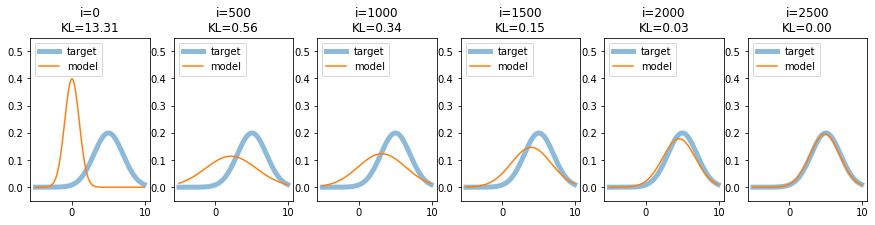

In [4]:
def KL_gaussians(mu1, sig1, mu2, sig2):
    return torch.log(sig2 / sig1) + ((torch.square(sig1) + torch.square(mu1 - mu2)) / (2. * torch.square(sig2))) - 0.5

def plot_two_gaussians(x, mu1, sig1, mu2, sig2, ax, title=None):
    mu1 = mu1.detach()
    sig1 = sig1.detach()
    mu2 = mu2.detach()
    sig2 = sig2.detach()

    p_1 = torch.distributions.Normal(loc=mu1, scale=sig1)
    p_2 = torch.distributions.Normal(loc=mu2, scale=sig2)

    ax.plot(x, torch.exp(p_1.log_prob(x)), label="target", linewidth=5., alpha=0.5)
    ax.plot(x, torch.exp(p_2.log_prob(x)), label="model")
    ax.set_ylim(-0.05, 0.55)
    ax.set_title(title)
    ax.legend(loc="upper left")

def train_gaussian(loss_fct):
    lr = 0.01
    n_steps = 2500
    theta = torch.tensor([0., 1.], dtype=torch.float32, requires_grad=True)
    target_params = torch.tensor([5., 2.], dtype=torch.float32, requires_grad=False)

    n_plots = 5
    fig, axes = plt.subplots(1, n_plots+1, figsize=(3 * n_plots, 3))
    x = torch.arange(-5., 10., 0.1)

    plot_two_gaussians(x, *target_params, *theta, axes[0], title=f'i={0}\nKL={float(loss_fct(*target_params, *theta)):.2f}')
    for i in range(1, n_steps+1):

        loss = loss_fct(*target_params, *theta)
        loss.backward()
        with torch.no_grad():
            theta.data = theta.data - lr * theta.grad
            theta.grad.data.zero_()

        if i % (n_steps // n_plots) == 0:
            plot_two_gaussians(x, *target_params, *theta, axes[i // (n_steps // n_plots)], title=f'i={i}\nKL={float(loss):.2f}')

train_gaussian(loss_fct=KL_gaussians)

When using a model that is sufficiently expressive to capture our target distribution, we could also recover the target distribution by minimising the reversed-KL $D_{KL}(q_\theta||p)$:

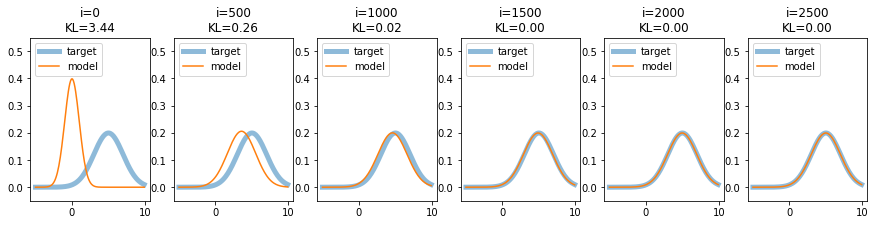

In [5]:
def revered_KL_gaussians(mu1, sig1, mu2, sig2):
    return KL_gaussians(mu2, sig2, mu1, sig1)

train_gaussian(loss_fct=revered_KL_gaussians)


The same result cannot be observed however when our model distribution is not expressive enough to recover the target distribution. This can be observed for example by trying to fit a mixture of gaussians using a single gaussian model. Since no closed-form expression is known to compute the KL-divergence between gaussian mixtures, we use a Monte-Carlo approximation with $N=10^4$.


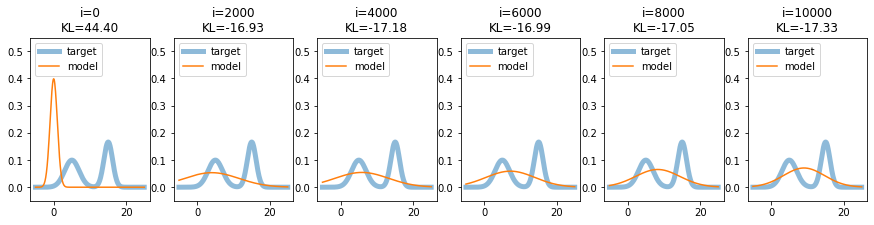

In [6]:
def approx_KL(mu_p1, sig_p1, mu_p2, sig_p2, mu_q, sig_q, N=10000):

    p_1 = torch.distributions.Normal(loc=mu_p1, scale=sig_p1)
    p_2 = torch.distributions.Normal(loc=mu_p2, scale=sig_p2)

    p1_samples = p_1.sample(sample_shape=(int(N/2),))
    p2_samples = p_2.sample(sample_shape=(N - len(p1_samples),))

    logprob_p1_samples = math.log(0.5) +  p_1.log_prob(p1_samples)
    logprob_p2_samples = math.log(0.5) +  p_2.log_prob(p1_samples)

    p_samples = torch.cat([p1_samples, p2_samples], dim=0)
    logprob_p_samples = torch.cat([logprob_p1_samples, logprob_p2_samples], dim=0)

    q = torch.distributions.Normal(loc=mu_q, scale=sig_q)
    logprob_q_samples = q.log_prob(p_samples)

    return torch.mean(logprob_p_samples - logprob_q_samples, dim=0)

def plot_mixtures_and_gaussian(x, mu_p1, sig_p1, mu_p2, sig_p2, mu_q, sig_q, ax, title=None):
    mu_q = mu_q.detach()
    sig_q = sig_q.detach()

    p_1 = torch.distributions.Normal(loc=mu_p1, scale=sig_p1)
    p_2 = torch.distributions.Normal(loc=mu_p2, scale=sig_p2)

    q = torch.distributions.Normal(loc=mu_q, scale=sig_q)

    ax.plot(x, (p_1.log_prob(x).exp() + p_2.log_prob(x).exp()) / 2., label="target", linewidth=5., alpha=0.5)
    ax.plot(x, q.log_prob(x).exp(), label="model")
    ax.set_ylim(-0.05, 0.55)
    ax.set_title(title)
    ax.legend(loc="upper left")

def train_gaussian(loss_fct):
    lr = 0.01
    n_steps = 10000
    theta = torch.tensor([0., 1.], dtype=torch.float32, requires_grad=True)
    target_params = torch.tensor([5., 2., 15., 1.2], dtype=torch.float32, requires_grad=False)

    n_plots = 5
    fig, axes = plt.subplots(1, n_plots+1, figsize=(3 * n_plots, 3))
    x = torch.arange(-5., 25., 0.1)

    plot_mixtures_and_gaussian(x, *target_params, *theta, axes[0], title=f'i=0\nKL={loss_fct(*target_params, *theta):.2f}')
    for i in range(1, n_steps+1):

        loss = loss_fct(*target_params, *theta)
        loss.backward()
        with torch.no_grad():
            theta.data = theta.data - lr * theta.grad
            theta.grad.data.zero_()

        if i % (n_steps // n_plots) == 0:
            plot_mixtures_and_gaussian(x, *target_params, *theta, axes[i // (n_steps // n_plots)], title=f'i={i}\nKL={float(loss):.2f}')

train_gaussian(loss_fct=approx_KL)

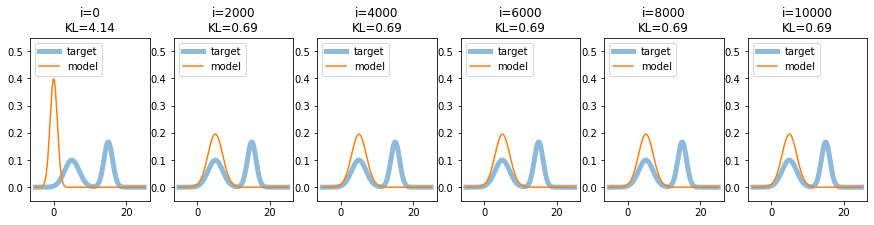

In [7]:
def approx_reversed_KL(mu_p1, sig_p1, mu_p2, sig_p2, mu_q, sig_q, N=10000):
    q = torch.distributions.Normal(loc=mu_q, scale=sig_q)
    q_samples = q.rsample(sample_shape=(N,))
    logprob_q_samples = q.log_prob(q_samples)

    p_1 = torch.distributions.Normal(loc=mu_p1, scale=sig_p1)
    p_2 = torch.distributions.Normal(loc=mu_p2, scale=sig_p2)

    logprob_p_samples = torch.log((p_1.log_prob(q_samples).exp() + p_2.log_prob(q_samples).exp()) / 2.)

    return torch.mean(logprob_q_samples - logprob_p_samples, dim=0)

train_gaussian(loss_fct=approx_reversed_KL)

We can see that using the KL-divergence as loss function yields a model that splits its probability mass to cover as much of the target distribution mass as possible, a behavior that we call *mean-seeking*.

Using the reversed-KL, we instead converge to a model that focuses on a single mode of the target distribution, to avoid as much as possible to put any of its mass on regions of $\mathcal{X}$ where $p(x)$ is very low, a behavior that we call *mode-seeking*.